<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [35]</a>'.</span>

# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [1]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 1
repeats = 10
importance_type = "split"

life_history = ["lifespan", "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
debug_local = True #to use local version

In [2]:
# Parameters
number_of_bootstraps = 5
lgb_params = {
    "boosting_type": "dart",
    "objective": "regression",
    "metric": ["l2", "l1"],
    "max_leaves": 20,
    "max_depth": 3,
    "learning_rate": 0.07,
    "feature_fraction": 0.8,
    "bagging_fraction": 1,
    "min_data_in_leaf": 6,
    "lambda_l1": 0.9,
    "lambda_l2": 0.9,
    "verbose": -1,
}
debug_local = False


In [3]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

In [4]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics
from yspecies.selection import ShapSelector
from yspecies.results import FeatureSummary

In [6]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [7]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: agg

### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [8]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

## Setting up Features to select ##

In [9]:
default_selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent"
)
default_selection

Samples metadata,Species metadata,Genes,Predict label,not_validated species
"['tissue', 'species']",[],all,lifespan,[]


In [10]:
loader = DataLoader(locations, default_selection)
selections = loader.load_life_history()
selections["lifespan"][0]

expressions,genes,species,samples,Genes Metadata,Species Metadata
"(408, 12323)","(12323, 37)",38,408,"(12323, 2)","(38, 18)"


### Loading Hyperoptimization studies ###

In [11]:
def load_study(trait: str):
    url = f'sqlite:///' +str((locations.interim.optimization / (trait+".sqlite")).absolute())
    print('loading (if exists) study from '+url)
    storage = optuna.storages.RDBStorage(
        url=url
        #engine_kwargs={'check_same_thread': False}
    )
    return optuna.multi_objective.study.create_study(directions=['maximize','minimize','maximize'], storage = storage, study_name = f"{trait}_r2_huber_kendall", load_if_exists = True)

## Setting up SHAP selection pipeline ##

### Deciding on selection parameters (which fields to include, exclude, predict)  ###

In [12]:
partition_params = PartitionParameters(n_folds, n_hold_out, 2,   42)


In [13]:
def make_pipeline(trait: str, study_name: str = None):
    study_name = trait if study_name is None else study_name
    study = load_study(study_name)
    if len(study.get_pareto_front_trials())>0 :
        metrics, params = MultiObjectiveResults.from_study(study).best_metrics_params_r2()
        params["verbose"] = -1
        if "early_stopping_round" not in params:
            params["early_stopping_round"] = 10
    else:
        params =  lgb_params = {"bagging_fraction": 0.9522534844058304,
                  "boosting_type": "dart",
                  "objective": "regression",
                  "feature_fraction": 0.42236910941558053,
                  "lambda_l1": 0.020847266580277746,
                  "lambda_l2": 2.8448564854773326,
                  "learning_rate": 0.11484015430016059,
                  "max_depth": 3,
                  "max_leaves": 35,
                  "min_data_in_leaf": 9,
                  "num_iterations": 250,
                  "metrics": ["l1", "l2", "huber"]
                 }
    partition_shap_pipe = Pipeline([
    ("partitioner", DataPartitioner()),
    ('prepare_for_selection', TupleWith(params)),
    ("shap_computation", ShapSelector())
    ]
    )
    repeated_cv =  Repeat(partition_shap_pipe, repeats, lambda x,i: (x[0], replace(x[1], seed = i)))
    return Pipeline(
        [
        ('extractor', DataExtractor()),
        ('prepare_for_partitioning', TupleWith(partition_params)), # to extract the data required for ML from the dataset
        ("partition_shap", repeated_cv),
        ("summarize", Collect(fold=lambda results: FeatureSummary(results)))
        ]
        )

In [14]:
pipelines = {trait:make_pipeline(trait) for trait in life_history}
pipelines.keys()

loading (if exists) study from sqlite:////data/sources/yspecies/data/interim/optimization/lifespan.sqlite

create_study is experimental (supported from v1.4.0). The interface can change in the future.


NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.


RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.


[I 2020-09-09 12:20:53,619]

 Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.

MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.


FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.


loading (if exists) study from sqlite:////data/sources/yspecies/data/interim/optimization/mass_kg.sqlite

[I 2020-09-09 12:20:55,513]

 Using an existing study with name 'mass_kg_r2_huber_kendall' instead of creating a new one.

loading (if exists) study from sqlite:////data/sources/yspecies/data/interim/optimization/mtGC.sqlite

[I 2020-09-09 12:20:55,775]

 Using an existing study with name 'mtGC_r2_huber_kendall' instead of creating a new one.

loading (if exists) study from sqlite:////data/sources/yspecies/data/interim/optimization/metabolic_rate.sqlite

[I 2020-09-09 12:20:57,252]

 Using an existing study with name 'metabolic_rate_r2_huber_kendall' instead of creating a new one.

loading (if exists) study from sqlite:////data/sources/yspecies/data/interim/optimization/temperature.sqlite

[I 2020-09-09 12:20:57,680]

 Using an existing study with name 'temperature_r2_huber_kendall' instead of creating a new one.

loading (if exists) study from sqlite:////data/sources/yspecies/data/interim/optimization/gestation_days.sqlite

[I 2020-09-09 12:20:58,072]

 Using an existing study with name 'gestation_days_r2_huber_kendall' instead of creating a new one.

dict_keys(['lifespan', 'mass_kg', 'mtGC', 'metabolic_rate', 'temperature', 'gestation_days'])

# First stage selection (shap ) #

In [15]:
stage_one = {}

### Lifespan ###

In [16]:
def run_stage_one(trait: str):
    result = pipelines[trait].fit_transform(selections[trait])
    stage_one[trait] = result #ugly mutation of stage_one dicionary
    return result

In [17]:
stage_one_lifespan = run_stage_one("lifespan")
stage_one_lifespan.selected

2020-09-09 12:20:59.568 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 0 =====


2020-09-09 12:20:59.569 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}


2020-09-09 12:20:59.610 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[136]	valid_0's l1: 9.45903	valid_0's l2: 229.227	valid_0's huber: 8.15653

2020-09-09 12:21:01.402 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[126]	valid_0's l1: 4.44458	valid_0's l2: 75.2891	valid_0's huber: 3.67282

2020-09-09 12:21:03.361 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[108]	valid_0's l1: 3.84279	valid_0's l2: 54.7746	valid_0's huber: 3.13819

2020-09-09 12:21:05.180 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[101]	valid_0's l1: 3.48671	valid_0's l2: 64.2862	valid_0's huber: 2.79989

2020-09-09 12:21:30.623 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.860975682304215, MAE=5.308276431042094, MSE=105.89426332067686, huber=4.438139881104791)


2020-09-09 12:21:30.693 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 1 =====


2020-09-09 12:21:30.694 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}


2020-09-09 12:21:30.731 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[121]	valid_0's l1: 3.66333	valid_0's l2: 33.3584	valid_0's huber: 2.94527

2020-09-09 12:21:32.597 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[141]	valid_0's l1: 5.23023	valid_0's l2: 114.173	valid_0's huber: 4.36805

2020-09-09 12:21:34.563 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[108]	valid_0's l1: 3.38211	valid_0's l2: 39.5527	valid_0's huber: 2.67708

2020-09-09 12:21:36.393 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

[250]	valid_0's l1: 6.07959	valid_0's l2: 159.098	valid_0's huber: 5.1493

Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 6.07952	valid_0's l2: 159.098	valid_0's huber: 5.1494

2020-09-09 12:22:09.255 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8771403494512424, MAE=4.588797523068958, MSE=86.5453145736023, huber=3.7867493140678814)


2020-09-09 12:22:09.327 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 2 =====


2020-09-09 12:22:09.328 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}


2020-09-09 12:22:09.363 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[87]	valid_0's l1: 3.96895	valid_0's l2: 45.8489	valid_0's huber: 3.21764

2020-09-09 12:22:11.139 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[115]	valid_0's l1: 4.9685	valid_0's l2: 88.3079	valid_0's huber: 4.11579

2020-09-09 12:22:13.190 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[114]	valid_0's l1: 3.37316	valid_0's l2: 32.1887	valid_0's huber: 2.66844

2020-09-09 12:22:15.208 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[180]	valid_0's l1: 7.61274	valid_0's l2: 123.532	valid_0's huber: 6.46436

2020-09-09 12:22:40.878 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8795354469467518, MAE=4.980837246550187, MSE=72.46932986591808, huber=4.115165144011104)


2020-09-09 12:22:40.951 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 3 =====


2020-09-09 12:22:40.952 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}


2020-09-09 12:22:40.987 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[118]	valid_0's l1: 3.72935	valid_0's l2: 36.1783	valid_0's huber: 2.99433

2020-09-09 12:22:42.813 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[204]	valid_0's l1: 7.79581	valid_0's l2: 170.284	valid_0's huber: 6.66516

2020-09-09 12:22:45.313 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[134]	valid_0's l1: 4.23858	valid_0's l2: 66.7263	valid_0's huber: 3.48441

2020-09-09 12:22:47.268 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[125]	valid_0's l1: 2.78445	valid_0's l2: 40.1982	valid_0's huber: 2.14856

2020-09-09 12:23:15.849 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8961796094674944, MAE=4.637046168723452, MSE=78.34662395054613, huber=3.8235683377972953)


2020-09-09 12:23:15.924 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 4 =====


2020-09-09 12:23:15.925 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}


2020-09-09 12:23:15.967 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[135]	valid_0's l1: 3.77436	valid_0's l2: 45.6228	valid_0's huber: 3.04124

2020-09-09 12:23:17.970 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[123]	valid_0's l1: 3.55795	valid_0's l2: 65.0764	valid_0's huber: 2.8754

2020-09-09 12:23:20.068 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[144]	valid_0's l1: 4.63762	valid_0's l2: 50.4576	valid_0's huber: 3.83988

2020-09-09 12:23:22.301 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[183]	valid_0's l1: 6.5324	valid_0's l2: 131.751	valid_0's huber: 5.54932

2020-09-09 12:23:51.604 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8998165426394379, MAE=4.625582525853453, MSE=73.22698623492539, huber=3.8247048240446464)


2020-09-09 12:23:51.676 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 5 =====


2020-09-09 12:23:51.677 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}


2020-09-09 12:23:51.713 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[132]	valid_0's l1: 2.96422	valid_0's l2: 23.2956	valid_0's huber: 2.32509

2020-09-09 12:23:53.703 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[114]	valid_0's l1: 4.34319	valid_0's l2: 74.457	valid_0's huber: 3.56172

2020-09-09 12:23:55.487 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[100]	valid_0's l1: 4.99543	valid_0's l2: 65.2522	valid_0's huber: 4.15122

2020-09-09 12:23:57.242 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[117]	valid_0's l1: 4.2208	valid_0's l2: 73.1518	valid_0's huber: 3.47395

2020-09-09 12:24:22.774 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9183501874913238, MAE=4.130907950369613, MSE=59.03914869574248, huber=3.378774833491482)


2020-09-09 12:24:22.848 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 6 =====


2020-09-09 12:24:22.849 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}


2020-09-09 12:24:22.883 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[129]	valid_0's l1: 3.87369	valid_0's l2: 43.4285	valid_0's huber: 3.14381

2020-09-09 12:24:24.934 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[93]	valid_0's l1: 3.76766	valid_0's l2: 59.4568	valid_0's huber: 3.06761

2020-09-09 12:24:26.769 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[78]	valid_0's l1: 2.46476	valid_0's l2: 22.603	valid_0's huber: 1.8853

2020-09-09 12:24:28.491 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[115]	valid_0's l1: 4.62613	valid_0's l2: 64.2812	valid_0's huber: 3.81188

2020-09-09 12:24:50.448 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9339717268738774, MAE=3.6830600381375493, MSE=47.44237198314559, huber=2.977643519152089)


2020-09-09 12:24:50.521 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 7 =====


2020-09-09 12:24:50.522 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}


2020-09-09 12:24:50.560 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[96]	valid_0's l1: 3.7583	valid_0's l2: 29.2706	valid_0's huber: 3.02095

2020-09-09 12:24:52.304 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[207]	valid_0's l1: 4.53587	valid_0's l2: 80.8418	valid_0's huber: 3.74688

2020-09-09 12:24:54.848 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[136]	valid_0's l1: 4.50201	valid_0's l2: 52.1369	valid_0's huber: 3.71327

2020-09-09 12:24:56.910 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[125]	valid_0's l1: 4.27706	valid_0's l2: 55.0561	valid_0's huber: 3.49644

2020-09-09 12:25:24.747 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9261637308111239, MAE=4.268310769408937, MSE=54.32637107002267, huber=3.4911532756097783)


2020-09-09 12:25:24.828 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 8 =====


2020-09-09 12:25:24.829 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}


2020-09-09 12:25:24.866 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[96]	valid_0's l1: 2.94918	valid_0's l2: 30.057	valid_0's huber: 2.30477

2020-09-09 12:25:28.026 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[95]	valid_0's l1: 4.24574	valid_0's l2: 57.0662	valid_0's huber: 3.48879

2020-09-09 12:25:29.953 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[170]	valid_0's l1: 3.82306	valid_0's l2: 49.9916	valid_0's huber: 3.10081

2020-09-09 12:25:32.206 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[130]	valid_0's l1: 3.82737	valid_0's l2: 60.1879	valid_0's huber: 3.11056

2020-09-09 12:25:58.437 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9303791884209787, MAE=3.711336866649953, MSE=49.32567431133089, huber=2.99691974515484)


2020-09-09 12:25:58.510 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 9 =====


2020-09-09 12:25:58.511 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}


2020-09-09 12:25:58.543 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[88]	valid_0's l1: 3.24105	valid_0's l2: 26.8233	valid_0's huber: 2.56484

2020-09-09 12:26:00.487 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[166]	valid_0's l1: 7.05939	valid_0's l2: 152.111	valid_0's huber: 6.00407

2020-09-09 12:26:02.627 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[133]	valid_0's l1: 5.55071	valid_0's l2: 67.4029	valid_0's huber: 4.63997

2020-09-09 12:26:06.051 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[134]	valid_0's l1: 7.00582	valid_0's l2: 154.12	valid_0's huber: 5.94782

2020-09-09 12:26:31.726 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8648537529854701, MAE=5.714241544412328, MSE=100.11435193841979, huber=4.7904642580329195)


,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000010219,DYRK4,10.000,8.375,0.263,8.250,0.261,8.000,0.249,8.000,0.211,8.000,0.265,5.000,0.210,8.250,0.401,8.750,0.226,10.500,0.316,9.000,0.248,10.000,0.246
ENSG00000204498,NFKBIL1,10.000,7.350,-0.141,5.500,-0.057,8.750,-0.030,7.250,-0.114,8.500,-0.190,7.250,-0.178,7.500,-0.082,5.250,-0.044,8.000,-0.312,8.000,-0.095,7.500,-0.305
ENSG00000066923,STAG3,10.000,5.525,0.438,5.250,0.378,4.000,0.397,8.500,0.447,4.000,0.446,6.000,0.505,5.250,0.390,6.250,0.438,5.750,0.511,4.000,0.441,6.250,0.423
ENSG00000185880,TRIM69,10.000,5.200,0.140,5.250,0.073,4.500,0.313,3.750,0.119,4.500,0.155,8.250,0.216,7.000,0.100,5.750,0.086,4.750,0.146,4.000,0.101,4.250,0.089
ENSG00000105672,ETV2,10.000,3.550,0.730,2.750,0.752,3.250,0.769,2.750,0.729,3.750,0.693,5.500,0.701,3.250,0.726,3.750,0.747,3.000,0.707,3.750,0.741,3.750,0.738
ENSG00000167515,TRAPPC2L,9.000,6.056,-0.168,nan,nan,4.750,-0.205,4.750,-0.137,7.750,-0.184,6.000,-0.072,6.250,-0.184,6.750,-0.200,7.000,-0.248,7.000,-0.120,4.250,-0.163
ENSG00000171121,KCNMB3,9.000,4.056,0.667,5.250,0.725,3.750,0.660,nan,nan,3.750,0.669,2.500,0.646,4.500,0.669,3.750,0.616,3.750,0.688,5.000,0.676,4.250,0.654
ENSG00000132436,FIGNL1,9.000,3.722,0.544,4.250,0.475,3.000,0.563,nan,nan,4.000,0.591,3.750,0.571,4.250,0.566,2.500,0.453,3.500,0.544,5.000,0.546,3.250,0.584
ENSG00000157343,ARMC12,9.000,2.639,0.629,3.000,0.625,2.000,0.632,nan,nan,3.250,0.606,1.750,0.626,3.250,0.649,2.250,0.711,3.750,0.610,2.250,0.556,2.250,0.648
ENSG00000170835,CEL,8.000,3.219,0.694,2.500,0.738,3.500,0.748,nan,nan,4.500,0.707,4.250,0.703,2.000,0.695,2.250,0.565,nan,nan,4.250,0.671,2.500,0.723


### Mass_kg ###

In [18]:
stage_one_mass = run_stage_one("mass_kg")
stage_one_mass.selected

2020-09-09 12:26:32.327 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 0 =====


2020-09-09 12:26:32.328 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}


2020-09-09 12:26:32.349 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Aotus_nancymaae']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 13.3421	valid_0's l2: 445.825	valid_0's huber: 11.6282

2020-09-09 12:26:34.531 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Sus_scrofa', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 32.5505	valid_0's l2: 2527.47	valid_0's huber: 28.9213

2020-09-09 12:26:36.979 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Cavia_porcellus']


[250]	valid_0's l1: 6.44605	valid_0's l2: 136.511	valid_0's huber: 5.44781

2020-09-09 12:26:39.176 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 8.26742	valid_0's l2: 172.383	valid_0's huber: 7.05276

2020-09-09 12:27:04.857 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8485481700144555, MAE=15.151503721679937, MSE=820.5468217523671, huber=13.262512306432136)


2020-09-09 12:27:04.904 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 1 =====


2020-09-09 12:27:04.905 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}


2020-09-09 12:27:04.926 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Mesocricetus_auratus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 13.1049	valid_0's l2: 649.322	valid_0's huber: 11.46

2020-09-09 12:27:07.540 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Rattus_norvegicus']


[250]	valid_0's l1: 6.13092	valid_0's l2: 171.041	valid_0's huber: 5.14274

2020-09-09 12:27:09.877 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Sus_scrofa']


[250]	valid_0's l1: 15.2171	valid_0's l2: 569.748	valid_0's huber: 13.3068

2020-09-09 12:27:12.516 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Cavia_porcellus']


[250]	valid_0's l1: 26.7688	valid_0's l2: 1371.43	valid_0's huber: 23.7106

2020-09-09 12:27:37.778 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8114980730930564, MAE=15.30541379125049, MSE=690.3855427300549, huber=13.405051508161213)


2020-09-09 12:27:37.825 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 2 =====


2020-09-09 12:27:37.826 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}


2020-09-09 12:27:37.847 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Meriones_unguiculatus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 4.43469	valid_0's l2: 130.821	valid_0's huber: 3.62287

2020-09-09 12:27:40.320 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Mesocricetus_auratus']


[250]	valid_0's l1: 7.70838	valid_0's l2: 276.304	valid_0's huber: 6.57229

2020-09-09 12:27:42.729 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Cavia_porcellus']


[250]	valid_0's l1: 4.25301	valid_0's l2: 78.4206	valid_0's huber: 3.46288

2020-09-09 12:27:45.126 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Aotus_nancymaae']


[250]	valid_0's l1: 29.2213	valid_0's l2: 1610.48	valid_0's huber: 25.9187

2020-09-09 12:28:10.162 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8576119805557245, MAE=11.404332159528785, MSE=524.0055712291748, huber=9.894175479805348)


2020-09-09 12:28:10.207 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 3 =====


2020-09-09 12:28:10.208 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}


2020-09-09 12:28:10.227 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Rattus_norvegicus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 11.7794	valid_0's l2: 404.186	valid_0's huber: 10.2577

2020-09-09 12:28:12.410 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 27.6127	valid_0's l2: 2568.29	valid_0's huber: 24.5031

2020-09-09 12:28:14.771 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Sus_scrofa', 'Aotus_nancymaae']


[250]	valid_0's l1: 28.0847	valid_0's l2: 2842.88	valid_0's huber: 24.8911

2020-09-09 12:28:17.175 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 10.909	valid_0's l2: 245.189	valid_0's huber: 9.43465

2020-09-09 12:28:42.551 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.715942725506429, MAE=19.596461582124284, MSE=1515.1366536843038, huber=17.27163264793603)


2020-09-09 12:28:42.598 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 4 =====


2020-09-09 12:28:42.599 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}


2020-09-09 12:28:42.620 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Heterocephalus_glaber']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 18.6989	valid_0's l2: 747.411	valid_0's huber: 16.4631

2020-09-09 12:28:44.895 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Aotus_nancymaae']


[250]	valid_0's l1: 20.157	valid_0's l2: 703.449	valid_0's huber: 17.7411

2020-09-09 12:28:49.499 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Homo_sapiens', 'Rattus_norvegicus']


[250]	valid_0's l1: 17.2206	valid_0's l2: 887.106	valid_0's huber: 15.108

2020-09-09 12:28:51.834 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 15.5397	valid_0's l2: 458.061	valid_0's huber: 13.596

2020-09-09 12:29:20.923 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8221948225865736, MAE=17.904038888779247, MSE=699.0068526636555, huber=15.727058672421402)


2020-09-09 12:29:20.977 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 5 =====


2020-09-09 12:29:20.979 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}


2020-09-09 12:29:21.003 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Heterocephalus_glaber']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 18.1693	valid_0's l2: 692.966	valid_0's huber: 15.9763

2020-09-09 12:29:23.498 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Suricata_suricatta']


[250]	valid_0's l1: 14.2218	valid_0's l2: 612.104	valid_0's huber: 12.4202

2020-09-09 12:29:25.693 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Sus_scrofa', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 32.1119	valid_0's l2: 2524.25	valid_0's huber: 28.511

2020-09-09 12:29:28.066 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Otolemur_garnettii']


[250]	valid_0's l1: 7.01175	valid_0's l2: 166.371	valid_0's huber: 5.92653

2020-09-09 12:29:55.862 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8088802262238413, MAE=17.878673494198317, MSE=998.921859590723, huber=15.708482842754394)


2020-09-09 12:29:55.913 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 6 =====


2020-09-09 12:29:55.914 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}


2020-09-09 12:29:55.938 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Ictidomys_tridecemlineatus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 12.8993	valid_0's l2: 466.238	valid_0's huber: 11.226

2020-09-09 12:29:58.196 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Otolemur_garnettii']


[250]	valid_0's l1: 22.2409	valid_0's l2: 1393.7	valid_0's huber: 19.6887

2020-09-09 12:30:00.406 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Sus_scrofa']


[250]	valid_0's l1: 17.4214	valid_0's l2: 1576.66	valid_0's huber: 15.2861

2020-09-09 12:30:02.619 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Homo_sapiens']


[250]	valid_0's l1: 29.2153	valid_0's l2: 1598.4	valid_0's huber: 25.9009

2020-09-09 12:30:30.484 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.6993167781975327, MAE=20.444239754671482, MSE=1258.7499095040753, huber=18.025435907176202)


2020-09-09 12:30:30.538 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 7 =====


2020-09-09 12:30:30.539 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}


2020-09-09 12:30:30.566 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 11.3563	valid_0's l2: 474.896	valid_0's huber: 9.82545

2020-09-09 12:30:33.238 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 17.5279	valid_0's l2: 738.663	valid_0's huber: 15.3881

2020-09-09 12:30:35.869 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Monodelphis_domestica']


[250]	valid_0's l1: 17.4364	valid_0's l2: 601.688	valid_0's huber: 15.2897

2020-09-09 12:30:38.126 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Rattus_norvegicus']


[250]	valid_0's l1: 7.08194	valid_0's l2: 155.613	valid_0's huber: 5.9942

2020-09-09 12:31:05.743 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.842247332560213, MAE=13.35062226377475, MSE=492.715139177908, huber=11.624350087863128)


2020-09-09 12:31:05.792 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 8 =====


2020-09-09 12:31:05.793 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}


2020-09-09 12:31:05.812 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Otolemur_garnettii']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 23.8751	valid_0's l2: 1322.6	valid_0's huber: 21.173

2020-09-09 12:31:10.986 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Homo_sapiens', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 31.3351	valid_0's l2: 2027.37	valid_0's huber: 27.8118

2020-09-09 12:31:13.191 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Callithrix_jacchus']


[250]	valid_0's l1: 20.138	valid_0's l2: 1108.02	valid_0's huber: 17.8235

2020-09-09 12:31:15.454 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Sus_scrofa']


[250]	valid_0's l1: 12.5898	valid_0's l2: 516.946	valid_0's huber: 10.9398

2020-09-09 12:31:42.329 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7299498857714628, MAE=21.98452854184054, MSE=1243.7348230338284, huber=19.437009477152277)


2020-09-09 12:31:42.381 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 9 =====


2020-09-09 12:31:42.382 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}


2020-09-09 12:31:42.404 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Monodelphis_domestica']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 14.3026	valid_0's l2: 659.99	valid_0's huber: 12.4787

2020-09-09 12:31:45.054 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Suricata_suricatta']


[250]	valid_0's l1: 17.4403	valid_0's l2: 860.812	valid_0's huber: 15.3553

2020-09-09 12:31:47.705 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 5.21492	valid_0's l2: 86.4547	valid_0's huber: 4.34632

2020-09-09 12:31:49.992 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Homo_sapiens']


[250]	valid_0's l1: 24.6386	valid_0's l2: 1476.01	valid_0's huber: 21.7903

2020-09-09 12:32:19.196 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8091649123643789, MAE=15.399116505148402, MSE=770.8173285998719, huber=13.492648050140154)


,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000144214,LYG1,7.000,10.429,0.408,6.250,0.413,17.750,0.406,11.000,0.319,nan,nan,5.000,0.417,7.250,0.544,nan,nan,nan,nan,17.000,0.454,8.750,0.306
ENSG00000124172,ATP5F1E,6.000,20.500,-0.299,nan,nan,nan,nan,2.250,-0.276,22.250,-0.386,27.000,-0.321,22.000,-0.367,7.500,-0.318,42.000,-0.126,nan,nan,nan,nan
ENSG00000054277,OPN3,5.000,54.900,0.150,34.250,0.164,nan,nan,66.750,0.267,32.250,0.105,71.000,0.200,nan,nan,nan,nan,nan,nan,nan,nan,70.250,0.012
ENSG00000066923,STAG3,5.000,26.450,0.154,38.750,0.222,nan,nan,11.500,0.147,30.750,0.095,nan,nan,14.250,0.148,nan,nan,37.000,0.160,nan,nan,nan,nan
ENSG00000126062,TMEM115,5.000,10.750,0.005,7.000,0.014,8.250,-0.090,nan,nan,nan,nan,10.000,0.035,nan,nan,nan,nan,nan,nan,8.250,0.168,20.250,-0.104
ENSG00000010219,DYRK4,4.000,21.188,0.212,23.000,0.245,nan,nan,nan,nan,17.750,0.173,nan,nan,22.000,0.228,nan,nan,22.000,0.200,nan,nan,nan,nan
ENSG00000107020,PLGRKT,4.000,13.000,0.015,10.250,-0.035,12.500,0.053,nan,nan,nan,nan,nan,nan,nan,nan,14.500,-0.066,nan,nan,14.750,0.110,nan,nan
ENSG00000270647,TAF15,4.000,11.750,0.043,nan,nan,13.250,0.023,11.250,0.005,nan,nan,13.250,0.094,nan,nan,nan,nan,nan,nan,nan,nan,9.250,0.049
ENSG00000152214,RIT2,4.000,2.875,0.065,2.750,0.089,2.250,0.080,nan,nan,nan,nan,4.000,0.018,nan,nan,nan,nan,nan,nan,nan,nan,2.500,0.073
ENSG00000164304,CAGE1,3.000,15.000,-0.191,19.250,-0.215,3.250,-0.214,nan,nan,22.500,-0.142,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### MtGC ###

In [19]:
stage_one_mtGC = run_stage_one("mtGC")
stage_one_mtGC.selected

2020-09-09 12:32:19.953 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 0 =====


2020-09-09 12:32:19.954 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}


2020-09-09 12:32:19.991 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Sus_scrofa']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[104]	valid_0's l1: 0.478724	valid_0's l2: 0.473509	valid_0's huber: 0.201354

2020-09-09 12:32:23.014 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[39]	valid_0's l1: 1.02058	valid_0's l2: 1.47366	valid_0's huber: 0.588529

2020-09-09 12:32:24.821 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Equus_caballus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[121]	valid_0's l1: 0.591852	valid_0's l2: 1.02221	valid_0's huber: 0.327309

2020-09-09 12:32:30.301 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[100]	valid_0's l1: 0.651227	valid_0's l2: 0.700004	valid_0's huber: 0.316245

2020-09-09 12:32:51.552 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8735531748595802, MAE=0.6855961213531605, MSE=0.917346100381866, huber=0.35865893011044464)


2020-09-09 12:32:51.619 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 1 =====


2020-09-09 12:32:51.621 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}


2020-09-09 12:32:51.657 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Felis_catus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[84]	valid_0's l1: 0.423146	valid_0's l2: 0.401722	valid_0's huber: 0.172858

2020-09-09 12:32:54.398 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[80]	valid_0's l1: 0.527124	valid_0's l2: 0.754368	valid_0's huber: 0.282179

2020-09-09 12:32:58.780 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[50]	valid_0's l1: 0.481812	valid_0's l2: 0.689243	valid_0's huber: 0.237233

2020-09-09 12:33:01.197 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

[250]	valid_0's l1: 0.547681	valid_0's l2: 0.752035	valid_0's huber: 0.268196

Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.547681	valid_0's l2: 0.752035	valid_0's huber: 0.268196

2020-09-09 12:33:26.611 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.911623843935351, MAE=0.49494095436268293, MSE=0.649341972808765, huber=0.2395606506218058)


2020-09-09 12:33:26.676 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 2 =====


2020-09-09 12:33:26.677 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}


2020-09-09 12:33:26.703 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Sus_scrofa']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[94]	valid_0's l1: 0.573004	valid_0's l2: 0.679099	valid_0's huber: 0.272191

2020-09-09 12:33:29.030 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

[250]	valid_0's l1: 0.551605	valid_0's l2: 0.596688	valid_0's huber: 0.24864

Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 0.551593	valid_0's l2: 0.596669	valid_0's huber: 0.248631

2020-09-09 12:33:32.045 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Felis_catus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

[250]	valid_0's l1: 0.553113	valid_0's l2: 0.761627	valid_0's huber: 0.271429

Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 0.553112	valid_0's l2: 0.761612	valid_0's huber: 0.271427

2020-09-09 12:33:35.368 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Equus_caballus', 'Pan_paniscus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[179]	valid_0's l1: 0.787205	valid_0's l2: 1.68224	valid_0's huber: 0.491742

2020-09-09 12:34:04.723 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9063659098056718, MAE=0.6162285295802585, MSE=0.9299058959058761, huber=0.32102179698460825)


2020-09-09 12:34:04.778 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 3 =====


2020-09-09 12:34:04.779 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}


2020-09-09 12:34:04.805 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Ursus_americanus', 'Phascolarctos_cinereus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[149]	valid_0's l1: 0.653539	valid_0's l2: 1.0689	valid_0's huber: 0.360877

2020-09-09 12:34:11.172 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Macaca_mulatta']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[137]	valid_0's l1: 0.929314	valid_0's l2: 3.2299	valid_0's huber: 0.636209

2020-09-09 12:34:14.532 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[94]	valid_0's l1: 0.792679	valid_0's l2: 1.44395	valid_0's huber: 0.476699

2020-09-09 12:34:17.091 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[7]	valid_0's l1: 0.871501	valid_0's l2: 1.73121	valid_0's huber: 0.528215

2020-09-09 12:34:31.772 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7430875834085277, MAE=0.8117582862825798, MSE=1.8684902645872836, huber=0.4861390227596827)


2020-09-09 12:34:31.825 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 4 =====


2020-09-09 12:34:31.826 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}


2020-09-09 12:34:31.854 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Vombatus_ursinus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[62]	valid_0's l1: 1.10123	valid_0's l2: 2.39726	valid_0's huber: 0.718852

2020-09-09 12:34:34.157 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_musculus', 'Macaca_nemestrina']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[85]	valid_0's l1: 0.810496	valid_0's l2: 1.1462	valid_0's huber: 0.453993

2020-09-09 12:34:36.789 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[116]	valid_0's l1: 0.797725	valid_0's l2: 1.56245	valid_0's huber: 0.474352

2020-09-09 12:34:39.807 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Capra_hircus', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[128]	valid_0's l1: 0.6453	valid_0's l2: 1.19209	valid_0's huber: 0.361946

2020-09-09 12:34:58.995 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7891555711970988, MAE=0.8386866645252151, MSE=1.574500612610871, huber=0.5023390482710913)


2020-09-09 12:34:59.049 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 5 =====


2020-09-09 12:34:59.050 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}


2020-09-09 12:34:59.077 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Vombatus_ursinus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

[250]	valid_0's l1: 0.619234	valid_0's l2: 0.948339	valid_0's huber: 0.348644

Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.619234	valid_0's l2: 0.948339	valid_0's huber: 0.348644

2020-09-09 12:35:03.271 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Sus_scrofa', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[93]	valid_0's l1: 0.489302	valid_0's l2: 0.899299	valid_0's huber: 0.254094

2020-09-09 12:35:05.990 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[163]	valid_0's l1: 0.595418	valid_0's l2: 0.862198	valid_0's huber: 0.328847

2020-09-09 12:35:09.132 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[97]	valid_0's l1: 0.649124	valid_0's l2: 0.972947	valid_0's huber: 0.358125

2020-09-09 12:35:35.859 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8737860688898453, MAE=0.5882695554621669, MSE=0.9206958062050792, huber=0.3224975526710979)


2020-09-09 12:35:35.912 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 6 =====


2020-09-09 12:35:35.913 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}


2020-09-09 12:35:35.940 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Ursus_americanus', 'Tupaia_belangeri']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[91]	valid_0's l1: 0.605769	valid_0's l2: 1.0416	valid_0's huber: 0.337539

2020-09-09 12:35:38.733 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[88]	valid_0's l1: 0.478837	valid_0's l2: 0.798489	valid_0's huber: 0.247114

2020-09-09 12:35:41.196 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[181]	valid_0's l1: 0.345218	valid_0's l2: 0.259429	valid_0's huber: 0.122635

2020-09-09 12:35:44.507 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[54]	valid_0's l1: 0.816399	valid_0's l2: 2.81008	valid_0's huber: 0.528305

2020-09-09 12:36:04.153 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8365383354409, MAE=0.5615557044883318, MSE=1.227399393024815, huber=0.30814467466556)


2020-09-09 12:36:04.205 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 7 =====


2020-09-09 12:36:04.206 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}


2020-09-09 12:36:04.233 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Sus_scrofa', 'Macaca_fascicularis']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[129]	valid_0's l1: 0.458733	valid_0's l2: 0.436492	valid_0's huber: 0.194139

2020-09-09 12:36:07.186 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[25]	valid_0's l1: 1.10289	valid_0's l2: 2.63805	valid_0's huber: 0.711355

2020-09-09 12:36:09.277 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[183]	valid_0's l1: 0.668857	valid_0's l2: 1.17441	valid_0's huber: 0.365626

2020-09-09 12:36:12.964 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Mus_musculus', 'Equus_caballus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[102]	valid_0's l1: 0.908522	valid_0's l2: 1.48671	valid_0's huber: 0.552053

2020-09-09 12:36:31.676 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8030569037077978, MAE=0.784749891330608, MSE=1.4339170675155786, huber=0.4518184795085066)


2020-09-09 12:36:31.729 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 8 =====


2020-09-09 12:36:31.730 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}


2020-09-09 12:36:31.756 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Ailuropoda_melanoleuca']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[152]	valid_0's l1: 0.562463	valid_0's l2: 0.755986	valid_0's huber: 0.282626

2020-09-09 12:36:35.487 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[55]	valid_0's l1: 0.59224	valid_0's l2: 0.744214	valid_0's huber: 0.296388

2020-09-09 12:36:37.687 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Mesocricetus_auratus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[89]	valid_0's l1: 1.02804	valid_0's l2: 2.82989	valid_0's huber: 0.710877

2020-09-09 12:36:40.563 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[146]	valid_0's l1: 0.567974	valid_0's l2: 0.672868	valid_0's huber: 0.280583

2020-09-09 12:37:01.501 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8456615414896915, MAE=0.6876783922265179, MSE=1.2507388191040372, huber=0.392833235658935)


2020-09-09 12:37:01.556 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 9 =====


2020-09-09 12:37:01.557 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}


2020-09-09 12:37:01.582 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Meriones_unguiculatus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[11]	valid_0's l1: 1.00392	valid_0's l2: 1.74339	valid_0's huber: 0.593614

2020-09-09 12:37:03.077 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[130]	valid_0's l1: 0.829213	valid_0's l2: 1.42613	valid_0's huber: 0.47907

2020-09-09 12:37:06.558 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Ailuropoda_melanoleuca', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[79]	valid_0's l1: 0.587505	valid_0's l2: 0.909156	valid_0's huber: 0.320914

2020-09-09 12:37:09.217 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[41]	valid_0's l1: 0.973238	valid_0's l2: 1.77864	valid_0's huber: 0.577021

2020-09-09 12:37:21.650 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.771141896946768, MAE=0.8484695237196214, MSE=1.4643304061387927, huber=0.49016532617805164)


,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000171121,KCNMB3,10.000,10.025,0.641,10.250,0.654,7.000,0.610,16.500,0.632,9.250,0.639,9.750,0.665,10.250,0.640,10.500,0.648,8.000,0.643,10.500,0.651,8.250,0.625
ENSG00000122034,GTF3A,10.000,9.650,0.632,10.750,0.627,13.000,0.642,10.250,0.685,11.000,0.669,10.750,0.583,6.250,0.639,12.000,0.641,7.500,0.675,6.500,0.571,8.500,0.591
ENSG00000144451,SPAG16,10.000,7.200,0.390,6.250,0.344,8.500,0.330,6.000,0.377,6.000,0.434,9.500,0.319,8.750,0.456,6.250,0.415,6.000,0.439,8.000,0.475,6.750,0.311
ENSG00000196419,XRCC6,8.000,11.375,0.637,8.750,0.685,12.750,0.607,8.000,0.665,nan,nan,13.750,0.650,12.750,0.613,11.000,0.634,10.250,0.649,13.750,0.593,nan,nan
ENSG00000167515,TRAPPC2L,8.000,4.031,-0.514,4.250,-0.532,3.750,-0.541,nan,nan,nan,nan,6.250,-0.564,4.750,-0.502,3.000,-0.513,3.000,-0.441,3.250,-0.545,4.000,-0.476
ENSG00000163528,CHCHD4,6.000,5.333,0.402,nan,nan,5.000,0.390,nan,nan,nan,nan,3.000,0.411,8.500,0.411,7.000,0.387,2.500,0.372,6.000,0.442,nan,nan
ENSG00000167272,POP5,6.000,5.292,-0.381,nan,nan,4.250,-0.383,nan,nan,nan,nan,6.750,-0.381,5.250,-0.460,6.000,-0.355,4.500,-0.365,5.000,-0.340,nan,nan
ENSG00000122952,ZWINT,6.000,3.292,-0.663,3.000,-0.646,3.250,-0.650,nan,nan,nan,nan,3.000,-0.660,3.500,-0.667,3.750,-0.649,nan,nan,nan,nan,3.250,-0.707
ENSG00000069869,NEDD4,6.000,2.542,0.010,4.250,0.155,nan,nan,1.000,0.472,2.250,-0.173,2.000,-0.192,nan,nan,nan,nan,2.000,-0.200,3.750,-0.005,nan,nan
ENSG00000168300,PCMTD1,5.000,7.900,0.149,6.250,0.188,8.750,0.091,nan,nan,nan,nan,nan,nan,7.750,0.128,11.250,0.133,5.500,0.203,nan,nan,nan,nan


### Metabolism ###

In [20]:
stage_one_metabolic_rate = run_stage_one("metabolic_rate")
stage_one_metabolic_rate.selected

2020-09-09 12:37:22.599 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 0 =====


2020-09-09 12:37:22.600 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}


2020-09-09 12:37:22.619 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Cavia_porcellus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 12.9298	valid_0's l2: 299.517	valid_0's huber: 11.2671

2020-09-09 12:37:26.863 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Sus_scrofa', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 23.1846	valid_0's l2: 1147.18	valid_0's huber: 20.484

2020-09-09 12:37:32.631 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Rattus_norvegicus']


[250]	valid_0's l1: 6.92015	valid_0's l2: 116.413	valid_0's huber: 5.84312

2020-09-09 12:37:36.929 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 25.9153	valid_0's l2: 1399.09	valid_0's huber: 23.0034

2020-09-09 12:38:05.865 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7945335871650265, MAE=17.23747331436197, MSE=740.5506064031485, huber=15.14942293494077)


2020-09-09 12:38:05.910 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 1 =====


2020-09-09 12:38:05.911 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}


2020-09-09 12:38:05.929 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Meriones_unguiculatus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 16.6079	valid_0's l2: 511.446	valid_0's huber: 14.5603

2020-09-09 12:38:10.183 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 10.3028	valid_0's l2: 225.13	valid_0's huber: 8.90378

2020-09-09 12:38:14.300 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Sus_scrofa']


[250]	valid_0's l1: 19.7717	valid_0's l2: 655.623	valid_0's huber: 17.4033

2020-09-09 12:38:19.718 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Rattus_norvegicus']


[250]	valid_0's l1: 17.3135	valid_0's l2: 1105.72	valid_0's huber: 15.2339

2020-09-09 12:38:46.481 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7880732362857129, MAE=15.99896526417836, MSE=624.4788064987699, huber=14.025339657643276)


2020-09-09 12:38:46.525 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 2 =====


2020-09-09 12:38:46.526 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}


2020-09-09 12:38:46.546 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Mus_musculus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 7.49281	valid_0's l2: 312.702	valid_0's huber: 6.3774

2020-09-09 12:38:50.980 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 12.9119	valid_0's l2: 441.071	valid_0's huber: 11.2439

2020-09-09 12:38:55.938 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Rattus_norvegicus']


[250]	valid_0's l1: 5.65935	valid_0's l2: 117.544	valid_0's huber: 4.72731

2020-09-09 12:38:59.535 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Cavia_porcellus']


[250]	valid_0's l1: 30.8805	valid_0's l2: 1845.47	valid_0's huber: 27.4037

2020-09-09 12:39:26.960 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7741022481439785, MAE=14.236155481783232, MSE=679.1976032604521, huber=12.438071101945848)


2020-09-09 12:39:27.006 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 3 =====


2020-09-09 12:39:27.007 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}


2020-09-09 12:39:27.026 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Ictidomys_tridecemlineatus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 12.8417	valid_0's l2: 428.119	valid_0's huber: 11.1704

2020-09-09 12:39:31.356 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 21.7377	valid_0's l2: 977.685	valid_0's huber: 19.1758

2020-09-09 12:39:35.476 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Sus_scrofa', 'Cavia_porcellus']


[250]	valid_0's l1: 14.2787	valid_0's l2: 481.611	valid_0's huber: 12.4572

2020-09-09 12:39:39.328 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Mus_musculus', 'Meriones_unguiculatus']


[250]	valid_0's l1: 17.6829	valid_0's l2: 663.79	valid_0's huber: 15.5345

2020-09-09 12:40:06.928 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8036655307879486, MAE=16.635218945775875, MSE=637.8010064167084, huber=14.5844609943197)


2020-09-09 12:40:06.971 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 4 =====


2020-09-09 12:40:06.972 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}


2020-09-09 12:40:06.990 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Rattus_norvegicus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 5.67151	valid_0's l2: 123.65	valid_0's huber: 4.72879

2020-09-09 12:40:10.863 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Homo_sapiens']


[250]	valid_0's l1: 32.098	valid_0's l2: 2232.7	valid_0's huber: 28.4907

2020-09-09 12:40:15.575 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 15.5909	valid_0's l2: 573.727	valid_0's huber: 13.6946

2020-09-09 12:40:20.495 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Monodelphis_domestica']


[250]	valid_0's l1: 17.9015	valid_0's l2: 498.779	valid_0's huber: 15.7154

2020-09-09 12:40:47.449 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7593791019663757, MAE=17.81549233100962, MSE=857.2139181507185, huber=15.657344404631983)


2020-09-09 12:40:47.497 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 5 =====


2020-09-09 12:40:47.498 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}


2020-09-09 12:40:47.516 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Mus_musculus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 11.0117	valid_0's l2: 417.251	valid_0's huber: 9.52131

2020-09-09 12:40:51.688 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Sus_scrofa']


[250]	valid_0's l1: 33.0368	valid_0's l2: 2128.17	valid_0's huber: 29.329

2020-09-09 12:40:56.616 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 13.9407	valid_0's l2: 496.123	valid_0's huber: 12.1749

2020-09-09 12:41:01.369 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Rattus_norvegicus']


[250]	valid_0's l1: 5.91478	valid_0's l2: 112.782	valid_0's huber: 4.97024

2020-09-09 12:41:27.789 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8353991493546684, MAE=15.975994511791308, MSE=788.5805062829171, huber=13.998839872228348)


2020-09-09 12:41:27.830 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 6 =====


2020-09-09 12:41:27.831 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}


2020-09-09 12:41:27.849 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Callithrix_jacchus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 9.82229	valid_0's l2: 356.646	valid_0's huber: 8.4663

2020-09-09 12:41:32.003 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Otolemur_garnettii']


[250]	valid_0's l1: 15.4328	valid_0's l2: 542.44	valid_0's huber: 13.5449

2020-09-09 12:41:35.801 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Mus_musculus', 'Sus_scrofa']


[250]	valid_0's l1: 4.2894	valid_0's l2: 65.7323	valid_0's huber: 3.48987

2020-09-09 12:41:39.515 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Meriones_unguiculatus']


[250]	valid_0's l1: 31.3193	valid_0's l2: 2011.44	valid_0's huber: 27.7839

2020-09-09 12:42:06.427 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7718983739980873, MAE=15.215949451054612, MSE=744.0641825567918, huber=13.321244532426777)


2020-09-09 12:42:06.477 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 7 =====


2020-09-09 12:42:06.478 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}


2020-09-09 12:42:06.498 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Callithrix_jacchus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 20.0925	valid_0's l2: 1051.53	valid_0's huber: 17.7205

2020-09-09 12:42:11.705 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 15.6413	valid_0's l2: 554.251	valid_0's huber: 13.7302

2020-09-09 12:42:16.686 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 10.2247	valid_0's l2: 360.571	valid_0's huber: 8.80431

2020-09-09 12:42:19.609 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 10.4262	valid_0's l2: 231.591	valid_0's huber: 8.99999

2020-09-09 12:42:47.845 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8202767956500678, MAE=14.096156404683278, MSE=549.4868881193744, huber=12.313747330790829)


2020-09-09 12:42:47.891 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 8 =====


2020-09-09 12:42:47.892 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}


2020-09-09 12:42:47.910 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Otolemur_garnettii']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 18.7097	valid_0's l2: 961.245	valid_0's huber: 16.4745

2020-09-09 12:42:51.460 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Homo_sapiens', 'Callithrix_jacchus']


[250]	valid_0's l1: 34.9677	valid_0's l2: 2175.13	valid_0's huber: 31.081

2020-09-09 12:42:54.850 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 11.9774	valid_0's l2: 362.313	valid_0's huber: 10.4149

2020-09-09 12:42:57.671 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Sus_scrofa']


[250]	valid_0's l1: 19.0748	valid_0's l2: 931.874	valid_0's huber: 16.8164

2020-09-09 12:43:24.110 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.724799994134867, MAE=21.182387259475497, MSE=1107.6412044337683, huber=18.696680579503266)


2020-09-09 12:43:24.153 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 9 =====


2020-09-09 12:43:24.154 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.7949279232062532, 'boosting_type': 'dart', 'drop_rate': 0.19407161947050122, 'feature_fraction': 0.8486129005166576, 'lambda_l1': 2.9464767054398204, 'lambda_l2': 0.817423041659147, 'learning_rate': 0.08579903520990408, 'max_depth': 7, 'max_leaves': 15, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}


2020-09-09 12:43:24.173 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Cavia_porcellus']


Found `early_stopping_round` in params. Will use it instead of argument


Early stopping is not available in dart mode


[250]	valid_0's l1: 15.3069	valid_0's l2: 615.13	valid_0's huber: 13.4155

2020-09-09 12:43:27.930 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 13.1859	valid_0's l2: 479.649	valid_0's huber: 11.5268

2020-09-09 12:43:33.461 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Mus_musculus']


[250]	valid_0's l1: 5.03709	valid_0's l2: 48.1837	valid_0's huber: 4.14782

2020-09-09 12:43:37.662 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Otolemur_garnettii']


[250]	valid_0's l1: 31.8386	valid_0's l2: 2012.26	valid_0's huber: 28.2706

2020-09-09 12:44:06.346 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7532232291971745, MAE=16.342121156276164, MSE=788.80540000597, huber=14.340174998612653)


,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000124172,ATP5F1E,6.000,27.708,-0.252,24.250,-0.228,12.250,-0.080,nan,nan,16.250,-0.369,nan,nan,30.500,-0.341,nan,nan,47.000,-0.232,nan,nan,36.000,-0.260
ENSG00000270647,TAF15,6.000,23.583,-0.107,nan,nan,25.750,-0.011,27.750,-0.035,14.500,-0.067,nan,nan,nan,nan,23.250,-0.145,24.000,-0.299,nan,nan,26.250,-0.082
ENSG00000107020,PLGRKT,5.000,29.850,0.011,21.250,-0.183,23.500,0.456,nan,nan,nan,nan,nan,nan,29.250,-0.034,36.250,-0.219,nan,nan,39.000,0.036,nan,nan
ENSG00000054277,OPN3,4.000,39.438,0.092,2.000,0.073,nan,nan,74.000,0.214,nan,nan,76.750,0.044,nan,nan,5.000,0.039,nan,nan,nan,nan,nan,nan
ENSG00000171747,LGALS4,4.000,6.625,-0.639,10.000,-0.692,nan,nan,2.750,-0.701,nan,nan,12.500,-0.442,nan,nan,1.250,-0.723,nan,nan,nan,nan,nan,nan
ENSG00000175806,MSRA,3.000,17.167,-0.036,26.000,0.074,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.750,0.107,5.750,-0.288
ENSG00000127952,STYXL1,3.000,9.750,0.291,nan,nan,11.250,0.106,nan,nan,nan,nan,9.250,0.471,8.750,0.297,nan,nan,nan,nan,nan,nan,nan,nan
ENSG00000134825,TMEM258,3.000,5.500,0.581,9.750,0.622,nan,nan,4.500,0.583,nan,nan,nan,nan,nan,nan,nan,nan,2.250,0.538,nan,nan,nan,nan
ENSG00000156467,UQCRB,3.000,3.000,-0.419,3.250,-0.643,nan,nan,nan,nan,3.250,-0.079,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.500,-0.536
ENSG00000198931,APRT,3.000,2.583,0.480,1.750,0.641,2.000,0.220,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.000,0.578,nan,nan,nan,nan


### Temperature ###

In [21]:
stage_one_temperature = run_stage_one("temperature")
stage_one_temperature.selected

2020-09-09 12:44:07.576 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 0 =====


2020-09-09 12:44:07.577 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}


2020-09-09 12:44:07.602 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Suricata_suricatta']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[95]	valid_0's l1: 0.37369	valid_0's l2: 0.281856	valid_0's huber: 0.127591

2020-09-09 12:44:09.285 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[39]	valid_0's l1: 1.14129	valid_0's l2: 2.16311	valid_0's huber: 0.716447

2020-09-09 12:44:10.780 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Mesocricetus_auratus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[41]	valid_0's l1: 0.725062	valid_0's l2: 0.944916	valid_0's huber: 0.368779

2020-09-09 12:44:12.372 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[143]	valid_0's l1: 0.436969	valid_0's l2: 0.412512	valid_0's huber: 0.169024

2020-09-09 12:44:25.228 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7656173069976194, MAE=0.6692532253355442, MSE=0.9506000254337995, huber=0.3446675412245815)


2020-09-09 12:44:25.277 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 1 =====


2020-09-09 12:44:25.279 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}


2020-09-09 12:44:25.303 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Equus_caballus', 'Macaca_mulatta']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[110]	valid_0's l1: 0.336947	valid_0's l2: 0.430651	valid_0's huber: 0.150981

2020-09-09 12:44:27.303 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[8]	valid_0's l1: 0.649716	valid_0's l2: 1.02427	valid_0's huber: 0.347902

2020-09-09 12:44:28.549 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

[250]	valid_0's l1: 0.385982	valid_0's l2: 0.24094	valid_0's huber: 0.118862

Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 0.385979	valid_0's l2: 0.240937	valid_0's huber: 0.118861

2020-09-09 12:44:31.148 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[30]	valid_0's l1: 1.03776	valid_0's l2: 1.61038	valid_0's huber: 0.628181

2020-09-09 12:44:47.240 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.761819347533132, MAE=0.602600614202098, MSE=0.8265588499578714, huber=0.300785308397436)


2020-09-09 12:44:47.295 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 2 =====


2020-09-09 12:44:47.296 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}


2020-09-09 12:44:47.326 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Suricata_suricatta']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[81]	valid_0's l1: 0.328861	valid_0's l2: 0.28267	valid_0's huber: 0.123526

2020-09-09 12:44:49.037 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Homo_sapiens', 'Monodelphis_domestica']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[82]	valid_0's l1: 1.76473	valid_0's l2: 6.85934	valid_0's huber: 1.31803

2020-09-09 12:44:50.772 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[99]	valid_0's l1: 0.374989	valid_0's l2: 0.459055	valid_0's huber: 0.166171

2020-09-09 12:44:52.870 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[123]	valid_0's l1: 0.499902	valid_0's l2: 0.46562	valid_0's huber: 0.212466

2020-09-09 12:45:08.557 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.5273044126558158, MAE=0.7421200628433637, MSE=2.016671055394191, huber=0.45492930378880786)


2020-09-09 12:45:08.609 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 3 =====


2020-09-09 12:45:08.610 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}


2020-09-09 12:45:08.641 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[117]	valid_0's l1: 0.465316	valid_0's l2: 0.817791	valid_0's huber: 0.247601

2020-09-09 12:45:10.513 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Felis_catus', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[10]	valid_0's l1: 1.52409	valid_0's l2: 3.55042	valid_0's huber: 1.04862

2020-09-09 12:45:11.788 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[71]	valid_0's l1: 0.603094	valid_0's l2: 0.848804	valid_0's huber: 0.334855

2020-09-09 12:45:13.483 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[169]	valid_0's l1: 0.360761	valid_0's l2: 0.449841	valid_0's huber: 0.151033

2020-09-09 12:45:30.235 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.620333373431082, MAE=0.7383155358763521, MSE=1.4167136231435682, huber=0.44286213525409734)


2020-09-09 12:45:30.298 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 4 =====


2020-09-09 12:45:30.299 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}


2020-09-09 12:45:30.325 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_musculus', 'Equus_caballus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[43]	valid_0's l1: 0.732383	valid_0's l2: 0.721734	valid_0's huber: 0.340217

2020-09-09 12:45:31.677 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[78]	valid_0's l1: 0.845946	valid_0's l2: 1.85554	valid_0's huber: 0.515295

2020-09-09 12:45:33.337 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[148]	valid_0's l1: 0.534062	valid_0's l2: 0.63999	valid_0's huber: 0.234917

2020-09-09 12:45:35.190 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Homo_sapiens']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[73]	valid_0's l1: 0.479106	valid_0's l2: 0.441366	valid_0's huber: 0.184781

2020-09-09 12:45:54.410 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7977662801139006, MAE=0.6478745296638073, MSE=0.9146574282968066, huber=0.3194508391150312)


2020-09-09 12:45:54.595 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 5 =====


2020-09-09 12:45:54.596 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}


2020-09-09 12:45:54.623 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Mus_musculus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[26]	valid_0's l1: 0.633086	valid_0's l2: 0.696292	valid_0's huber: 0.283098

2020-09-09 12:45:56.035 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[28]	valid_0's l1: 0.858747	valid_0's l2: 1.25545	valid_0's huber: 0.47743

2020-09-09 12:45:58.304 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[32]	valid_0's l1: 2.30719	valid_0's l2: 9.15309	valid_0's huber: 1.76673

2020-09-09 12:46:00.167 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[43]	valid_0's l1: 0.491173	valid_0's l2: 0.72978	valid_0's huber: 0.233478

2020-09-09 12:46:25.367 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.2276364696383777, MAE=1.0725500817060494, MSE=2.9586508773368427, huber=0.6879220071401863)


2020-09-09 12:46:25.419 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 6 =====


2020-09-09 12:46:25.420 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}


2020-09-09 12:46:25.442 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Bos_taurus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[108]	valid_0's l1: 0.328107	valid_0's l2: 0.243931	valid_0's huber: 0.113712

2020-09-09 12:46:27.220 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[174]	valid_0's l1: 0.740335	valid_0's l2: 1.39047	valid_0's huber: 0.428787

2020-09-09 12:46:29.227 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Homo_sapiens', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[125]	valid_0's l1: 0.379545	valid_0's l2: 0.378241	valid_0's huber: 0.150175

2020-09-09 12:46:31.070 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[55]	valid_0's l1: 0.716867	valid_0's l2: 1.15387	valid_0's huber: 0.411271

2020-09-09 12:46:53.629 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8280073695794936, MAE=0.5412132677750648, MSE=0.7916261979130224, huber=0.276539555027988)


2020-09-09 12:46:53.816 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 7 =====


2020-09-09 12:46:53.817 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}


2020-09-09 12:46:53.848 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Ovis_aries']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[201]	valid_0's l1: 0.602746	valid_0's l2: 0.731783	valid_0's huber: 0.299544

2020-09-09 12:46:56.172 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[1]	valid_0's l1: 2.81867	valid_0's l2: 11.6802	valid_0's huber: 2.18273

2020-09-09 12:46:57.355 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Mesocricetus_auratus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[26]	valid_0's l1: 0.736098	valid_0's l2: 0.784876	valid_0's huber: 0.350361

2020-09-09 12:46:58.814 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Mus_musculus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[18]	valid_0's l1: 0.626701	valid_0's l2: 0.620997	valid_0's huber: 0.27307

2020-09-09 12:47:12.396 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.2633339608824353, MAE=1.1960542050677738, MSE=3.4544713077328093, huber=0.7715325967484123)


2020-09-09 12:47:12.849 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 8 =====


2020-09-09 12:47:12.850 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}


2020-09-09 12:47:12.875 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Pan_troglodytes']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[38]	valid_0's l1: 0.556471	valid_0's l2: 0.826146	valid_0's huber: 0.296646

2020-09-09 12:47:14.336 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[157]	valid_0's l1: 0.438338	valid_0's l2: 0.487169	valid_0's huber: 0.210695

2020-09-09 12:47:16.258 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Equus_caballus', 'Felis_catus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[46]	valid_0's l1: 0.768688	valid_0's l2: 1.59933	valid_0's huber: 0.474754

2020-09-09 12:47:17.716 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[82]	valid_0's l1: 0.464267	valid_0's l2: 0.445758	valid_0's huber: 0.207583

2020-09-09 12:47:33.444 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.78651276387957, MAE=0.5569412044982066, MSE=0.8396020324750958, huber=0.29628404435073613)


2020-09-09 12:47:33.583 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 9 =====


2020-09-09 12:47:33.585 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9219040738483888, 'boosting_type': 'gbdt', 'drop_rate': 0.14333380957397163, 'feature_fraction': 0.4690000754748763, 'lambda_l1': 0.4937008772491574, 'lambda_l2': 2.2888258490505713, 'learning_rate': 0.08533038187327897, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}


2020-09-09 12:47:33.608 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Monodelphis_domestica']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[60]	valid_0's l1: 2.53959	valid_0's l2: 11.1303	valid_0's huber: 1.971

2020-09-09 12:47:35.070 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[202]	valid_0's l1: 0.679574	valid_0's l2: 0.814307	valid_0's huber: 0.341104

2020-09-09 12:47:37.232 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Felis_catus', 'Otolemur_garnettii']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[87]	valid_0's l1: 0.73849	valid_0's l2: 1.08005	valid_0's huber: 0.392066

2020-09-09 12:47:38.902 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Mus_musculus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[33]	valid_0's l1: 1.09689	valid_0's l2: 2.00601	valid_0's huber: 0.646606

2020-09-09 12:47:57.162 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=-0.033497055220625405, MAE=1.2636365478863747, MSE=3.7576705676926876, huber=0.8377271889400643)


,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000087460,GNAS,8.000,17.500,0.334,17.000,0.339,15.500,0.384,17.250,0.230,nan,nan,20.250,0.298,11.000,0.323,23.000,0.414,nan,nan,20.750,0.376,15.250,0.310
ENSG00000092531,SNAP23,4.000,4.125,0.514,nan,nan,4.250,0.480,nan,nan,nan,nan,4.250,0.556,nan,nan,5.000,0.509,nan,nan,3.000,0.512,nan,nan
ENSG00000134717,BTF3L4,3.000,4.583,0.514,nan,nan,nan,nan,nan,nan,nan,nan,3.750,0.507,nan,nan,4.250,0.505,nan,nan,5.750,0.529,nan,nan
ENSG00000156467,UQCRB,3.000,4.333,-0.391,5.000,-0.359,nan,nan,nan,nan,nan,nan,3.000,-0.434,5.000,-0.380,nan,nan,nan,nan,nan,nan,nan,nan
ENSG00000127184,COX7C,3.000,4.333,-0.637,nan,nan,nan,nan,4.500,-0.652,nan,nan,nan,nan,nan,nan,3.750,-0.564,nan,nan,4.750,-0.696,nan,nan
ENSG00000173890,GPR160,3.000,4.250,0.532,nan,nan,nan,nan,nan,nan,nan,nan,3.750,0.447,nan,nan,5.500,0.710,nan,nan,nan,nan,3.500,0.439
ENSG00000136942,RPL35,3.000,3.250,-0.666,nan,nan,nan,nan,4.750,-0.719,nan,nan,nan,nan,nan,nan,nan,nan,1.750,-0.721,3.250,-0.560,nan,nan
ENSG00000176731,RBIS,2.000,5.125,-0.432,nan,nan,nan,nan,nan,nan,nan,nan,5.250,-0.448,nan,nan,nan,nan,nan,nan,5.000,-0.415,nan,nan
ENSG00000099341,PSMD8,2.000,4.125,0.433,4.500,0.355,nan,nan,nan,nan,nan,nan,3.750,0.511,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ENSG00000120656,TAF12,2.000,3.250,0.474,nan,nan,nan,nan,nan,nan,3.000,0.531,nan,nan,nan,nan,3.500,0.418,nan,nan,nan,nan,nan,nan


### Gestation ###

In [22]:
stage_one_gestation = run_stage_one("gestation_days")
stage_one_gestation.selected

2020-09-09 12:47:59.432 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 0 =====


2020-09-09 12:47:59.433 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}


2020-09-09 12:47:59.467 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Homo_sapiens', 'Pan_paniscus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[223]	valid_0's l1: 39.8955	valid_0's l2: 4547.51	valid_0's huber: 35.5331

2020-09-09 12:48:02.855 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Capra_hircus', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[103]	valid_0's l1: 14.7475	valid_0's l2: 669.363	valid_0's huber: 12.8995

2020-09-09 12:48:04.775 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Cavia_aperea', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[64]	valid_0's l1: 18.717	valid_0's l2: 748.588	valid_0's huber: 16.4639

2020-09-09 12:48:06.925 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[181]	valid_0's l1: 14.2615	valid_0's l2: 634.735	valid_0's huber: 12.4459

2020-09-09 12:49:33.927 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7833080818635968, MAE=21.905377270694732, MSE=1650.0499828214374, huber=19.339997803642905)


2020-09-09 12:49:34.304 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 1 =====


2020-09-09 12:49:34.305 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}


2020-09-09 12:49:34.339 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Macaca_mulatta']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[141]	valid_0's l1: 13.4836	valid_0's l2: 680.336	valid_0's huber: 11.7655

2020-09-09 12:49:36.893 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Capra_hircus', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[112]	valid_0's l1: 11.6219	valid_0's l2: 510.012	valid_0's huber: 10.0959

2020-09-09 12:49:38.864 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[152]	valid_0's l1: 12.3634	valid_0's l2: 417.875	valid_0's huber: 10.7667

2020-09-09 12:49:41.230 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[140]	valid_0's l1: 33.0515	valid_0's l2: 3706.17	valid_0's huber: 29.3742

2020-09-09 12:51:04.551 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8381551760751391, MAE=17.63011859835477, MSE=1328.5975929805613, huber=15.50351995102506)


2020-09-09 12:51:04.994 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 2 =====


2020-09-09 12:51:04.995 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}


2020-09-09 12:51:05.194 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Macaca_mulatta']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[137]	valid_0's l1: 19.872	valid_0's l2: 1086.05	valid_0's huber: 17.5151

2020-09-09 12:51:07.847 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[117]	valid_0's l1: 21.2827	valid_0's l2: 970.211	valid_0's huber: 18.7731

2020-09-09 12:51:10.229 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Macaca_fascicularis']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[79]	valid_0's l1: 16.3751	valid_0's l2: 764.094	valid_0's huber: 14.3564

2020-09-09 12:51:12.288 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Rattus_norvegicus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[100]	valid_0's l1: 14.9534	valid_0's l2: 480.611	valid_0's huber: 13.06

2020-09-09 12:52:19.542 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8847921007631426, MAE=18.120803172962468, MSE=825.2420220711606, huber=15.935258321115594)


2020-09-09 12:52:19.996 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 3 =====


2020-09-09 12:52:19.997 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}


2020-09-09 12:52:20.036 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Ailuropoda_melanoleuca', 'Pan_paniscus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[210]	valid_0's l1: 15.7742	valid_0's l2: 831.349	valid_0's huber: 13.831

2020-09-09 12:52:23.311 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Homo_sapiens']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[160]	valid_0's l1: 44.1163	valid_0's l2: 5421.13	valid_0's huber: 39.3316

2020-09-09 12:52:25.828 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Cavia_aperea', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[70]	valid_0's l1: 18.8197	valid_0's l2: 802.455	valid_0's huber: 16.5597

2020-09-09 12:52:28.832 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Ovis_aries', 'Mus_caroli']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[181]	valid_0's l1: 11.5843	valid_0's l2: 341.12	valid_0's huber: 10.0477

2020-09-09 12:54:03.126 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7991019400035727, MAE=22.573623062067877, MSE=1849.0126767697511, huber=19.94836131399671)


2020-09-09 12:54:03.545 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 4 =====


2020-09-09 12:54:03.546 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}


2020-09-09 12:54:03.666 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Bos_taurus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[107]	valid_0's l1: 25.3809	valid_0's l2: 3100.71	valid_0's huber: 22.462

2020-09-09 12:54:06.073 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Macaca_mulatta']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[140]	valid_0's l1: 17.3843	valid_0's l2: 880.515	valid_0's huber: 15.2632

2020-09-09 12:54:08.209 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Capra_hircus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[153]	valid_0's l1: 14.2124	valid_0's l2: 494.106	valid_0's huber: 12.4086

2020-09-09 12:54:10.866 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Homo_sapiens']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[137]	valid_0's l1: 42.7194	valid_0's l2: 4986.46	valid_0's huber: 38.0758

2020-09-09 12:55:32.448 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.69417020735901, MAE=24.924247859085554, MSE=2365.4472067535435, huber=22.057212974165004)


2020-09-09 12:55:32.910 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 5 =====


2020-09-09 12:55:32.911 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}


2020-09-09 12:55:33.046 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Sus_scrofa', 'Suricata_suricatta']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[132]	valid_0's l1: 15.0922	valid_0's l2: 853.918	valid_0's huber: 13.2174

2020-09-09 12:55:35.534 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Capra_hircus', 'Macaca_mulatta']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[149]	valid_0's l1: 15.7404	valid_0's l2: 798.796	valid_0's huber: 13.7943

2020-09-09 12:55:37.817 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[37]	valid_0's l1: 24.4925	valid_0's l2: 1469.59	valid_0's huber: 21.6437

2020-09-09 12:55:39.521 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Aotus_nancymaae']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[132]	valid_0's l1: 13.9849	valid_0's l2: 441.781	valid_0's huber: 12.2035

2020-09-09 12:56:52.130 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8746478666985256, MAE=17.327509829825896, MSE=891.021408898252, huber=15.12619590576463)


2020-09-09 12:56:52.581 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 6 =====


2020-09-09 12:56:52.582 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}


2020-09-09 12:56:52.709 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Ovis_aries', 'Capra_hircus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[158]	valid_0's l1: 18.7889	valid_0's l2: 1083.87	valid_0's huber: 16.5405

2020-09-09 12:56:55.455 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[97]	valid_0's l1: 21.0807	valid_0's l2: 1156.4	valid_0's huber: 18.5825

2020-09-09 12:56:57.461 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[99]	valid_0's l1: 13.9467	valid_0's l2: 536.356	valid_0's huber: 12.1804

2020-09-09 12:56:59.460 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Callithrix_jacchus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[164]	valid_0's l1: 22.4124	valid_0's l2: 2314.65	valid_0's huber: 19.8006

2020-09-09 12:58:17.659 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8301438623716203, MAE=19.057175574303884, MSE=1272.8197765429286, huber=16.779069702265996)


2020-09-09 12:58:18.018 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 7 =====


2020-09-09 12:58:18.019 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}


2020-09-09 12:58:18.054 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Tupaia_belangeri']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[109]	valid_0's l1: 18.2419	valid_0's l2: 1075.94	valid_0's huber: 16.0612

2020-09-09 12:58:20.492 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[102]	valid_0's l1: 18.0209	valid_0's l2: 792.208	valid_0's huber: 15.8395

2020-09-09 12:58:23.840 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[215]	valid_0's l1: 24.6059	valid_0's l2: 1432.84	valid_0's huber: 21.757

2020-09-09 12:58:27.060 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Sus_scrofa', 'Macaca_mulatta']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[132]	valid_0's l1: 11.3228	valid_0's l2: 311.171	valid_0's huber: 9.81085

2020-09-09 12:59:02.918 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8720800604143756, MAE=18.047880264714383, MSE=903.0396752342944, huber=15.868618609178018)


2020-09-09 12:59:03.015 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 8 =====


2020-09-09 12:59:03.016 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}


2020-09-09 12:59:03.067 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Felis_catus']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[138]	valid_0's l1: 24.8157	valid_0's l2: 1522.6	valid_0's huber: 21.9585

2020-09-09 12:59:05.306 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[190]	valid_0's l1: 18.5887	valid_0's l2: 1125.21	valid_0's huber: 16.3767

2020-09-09 12:59:08.314 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[92]	valid_0's l1: 14.1578	valid_0's l2: 552.29	valid_0's huber: 12.3693

2020-09-09 12:59:10.259 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[155]	valid_0's l1: 15.4842	valid_0's l2: 573.326	valid_0's huber: 13.5537

2020-09-09 12:59:44.439 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.8760741610143041, MAE=18.26161480281252, MSE=943.3563176465734, huber=16.067217961308856)


2020-09-09 12:59:44.549 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 9 =====


2020-09-09 12:59:44.550 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.9550809144864345, 'boosting_type': 'gbdt', 'drop_rate': 0.1520029135951902, 'feature_fraction': 0.39359679175101914, 'lambda_l1': 2.2144413347584315, 'lambda_l2': 2.012506929626787, 'learning_rate': 0.0890025107137548, 'max_depth': 3, 'max_leaves': 18, 'min_data_in_leaf': 5, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}


2020-09-09 12:59:44.592 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Canis_lupus_familiaris']


Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[64]	valid_0's l1: 22.1414	valid_0's l2: 1274.48	valid_0's huber: 19.5482

2020-09-09 12:59:46.538 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Bos_taurus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[69]	valid_0's l1: 29.7352	valid_0's l2: 3122.76	valid_0's huber: 26.3808

2020-09-09 12:59:48.711 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mus_musculus', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[192]	valid_0's l1: 15.396	valid_0's l2: 797.497	valid_0's huber: 13.482

2020-09-09 12:59:51.268 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds

Training until validation scores don't improve for 10 rounds

Early stopping, best iteration is:
[74]	valid_0's l1: 34.7252	valid_0's l2: 3528.39	valid_0's huber: 30.8726

2020-09-09 13:00:36.299 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.7206068064267933, MAE=25.499474903570643, MSE=2180.783212310389, huber=22.571443975436978)


,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000006282,SPATA20,10.000,7.400,0.660,5.500,0.652,5.500,0.641,9.250,0.652,6.250,0.670,7.250,0.676,7.250,0.664,9.000,0.641,8.250,0.668,8.500,0.655,7.250,0.686
ENSG00000066923,STAG3,10.000,6.500,0.424,6.250,0.401,5.250,0.375,6.750,0.388,8.250,0.449,6.000,0.463,5.750,0.443,7.500,0.421,8.000,0.441,3.750,0.485,7.500,0.374
ENSG00000171121,KCNMB3,10.000,5.900,0.623,5.500,0.616,5.250,0.645,6.000,0.603,7.750,0.614,4.500,0.641,5.250,0.609,6.500,0.645,5.500,0.631,9.000,0.638,3.750,0.585
ENSG00000172531,PPP1CA,9.000,5.250,-0.755,8.000,-0.835,7.000,-0.787,4.750,-0.762,5.250,-0.757,nan,nan,3.750,-0.724,5.250,-0.776,7.000,-0.806,1.500,-0.668,4.750,-0.680
ENSG00000105672,ETV2,9.000,4.083,0.681,4.750,0.672,4.500,0.697,6.250,0.685,4.250,0.694,4.250,0.671,3.250,0.693,2.500,0.681,3.250,0.645,nan,nan,3.750,0.694
ENSG00000188747,NOXA1,9.000,3.944,0.651,3.750,0.637,3.500,0.617,4.500,0.653,4.250,0.650,3.250,0.676,4.500,0.677,3.500,0.689,4.250,0.651,nan,nan,4.000,0.612
ENSG00000010219,DYRK4,8.000,11.219,0.474,13.250,0.647,15.250,0.640,10.750,0.360,nan,nan,13.250,0.425,7.750,0.303,10.500,0.551,9.000,0.577,10.000,0.289,nan,nan
ENSG00000163584,RPL22L1,7.000,4.214,-0.586,3.500,-0.470,3.500,-0.533,4.750,-0.649,nan,nan,4.500,-0.648,4.000,-0.650,nan,nan,4.250,-0.573,5.000,-0.579,nan,nan
ENSG00000165568,AKR1E2,7.000,4.071,-0.519,2.250,-0.507,4.000,-0.432,5.500,-0.523,4.250,-0.486,4.750,-0.640,nan,nan,nan,nan,3.750,-0.507,4.000,-0.536,nan,nan
ENSG00000101190,TCFL5,7.000,2.929,0.650,3.000,0.677,3.250,0.656,2.250,0.599,nan,nan,2.750,0.641,3.250,0.657,nan,nan,3.250,0.657,2.750,0.664,nan,nan


## Intersect first stages ##

In [23]:
genes = FeatureSummary.concat(stage_one, 2)
genes.shape

(142,)

In [24]:
genes.to_list()

['DYRK4',
 'NFKBIL1',
 'STAG3',
 'TRIM69',
 'ETV2',
 'TRAPPC2L',
 'KCNMB3',
 'FIGNL1',
 'ARMC12',
 'CEL',
 'NOXA1',
 'CHCHD3',
 'TERT',
 'DCTD',
 'SPAG16',
 'PPP1CA',
 'MAN2B2',
 'VPS28',
 'RNH1',
 'NOXRED1',
 'RAD51C',
 'DPP9',
 'CATSPER3',
 'ENAM',
 'FECH',
 'CALCOCO2',
 'NDUFA6',
 'LRR1',
 'CA3',
 'TSPAN10',
 'ATAT1',
 'RPL13A',
 'CLIC1',
 'TIMP1',
 'HSD17B1',
 'NEIL1',
 'LYG1',
 'ATP5F1E',
 'OPN3',
 'TMEM115',
 'PLGRKT',
 'TAF15',
 'RIT2',
 'CAGE1',
 'CTBS',
 'PABPC1L',
 'GTF3A',
 'XRCC6',
 'CHCHD4',
 'POP5',
 'ZWINT',
 'NEDD4',
 'PCMTD1',
 'SPATA20',
 'NEIL2',
 'EIF3K',
 'YES1',
 'LGALS4',
 'SFR1',
 'MRPL43',
 'TSPAN17',
 'AKR7L',
 'TCFL5',
 'CETN1',
 'GPAT3',
 'ELOC',
 'ATP5PD',
 'CAPN3',
 'MOSPD1',
 'PRSS53',
 'ZC3H15',
 'EMC9',
 'MRPL45',
 'PARP4',
 'PKN3',
 'YIPF6',
 'TSPAN31',
 'YWHAQ',
 'CALR3',
 'DTYMK',
 'PSMG3',
 'C12orf73',
 'STRC',
 'MPEG1',
 'RPL22L1',
 'PLXDC2',
 'ERMAP',
 'RPS17',
 'LYPLA1',
 'TESC',
 'DMAC1',
 'BRCA2',
 'AKR1E2',
 'RPL28',
 'NUCKS1',
 'UPP2',
 'MSRA',
 'STYXL1',
 'TMEM258',
 'UQCRB',
 'APRT',
 'CENPT',
 'MLYCD',
 'NDUFA4',
 'NDUFAF2',
 'RBFA',
 'CCR3',
 'USB1',
 'ZDHHC12',
 'C6orf89',
 'VMO1',
 'SLC25A43',
 'CHRNE',
 'GNAS',
 'SNAP23',
 'BTF3L4',
 'COX7C',
 'GPR160',
 'RPL35',
 'RBIS',
 'PSMD8',
 'TAF12',
 'EIF4EBP1',
 'PRMT1',
 'MPV17',
 'CXorf56',
 'CNPY3',
 'MEMO1',
 'SEC11C',
 'MPC1',
 'DNAJC15',
 'GPT',
 'TMEM223',
 'CREB3L4',
 'NSL1',
 'SARNP',
 'MMP21',
 'MRTO4',
 'LHX8',
 'ZSWIM7',
 'RPS8',
 'XRCC5']

## Second stage selection ##

In [25]:
lifespan_selection = selections["lifespan"]

In [26]:
initial_data = lifespan_selection[0] #.by_genes()

In [27]:
genes.to_csv(locations.interim.dir / "stage_1_results_concatenated.tsv", sep="\t")

In [28]:
stage_two_data = initial_data.by_genes.collect(lambda gs: gs.loc[genes.index.to_list()])
stage_two_data.name = "stage_2_input"
stage_two_data

expressions,genes,species,samples,Genes Metadata,Species Metadata
"(408, 142)","(142, 37)",38,408,"(142, 2)","(38, 18)"


In [29]:
stage_two_data.write(locations.interim.dir)

written stage_2_input dataset content to data/interim/stage_2_input

PosixPath('data/interim/stage_2_input')

In [30]:
stage_two_selection = (stage_two_data,lifespan_selection[1])

# Stage II Selection #

# Check untuned performance #

In [31]:
summary_stage_one_plot_path = locations.output.dir / "plots" / "stage_one_summary_lifespan.svg"
summary_stage_two_untuned_plot_path = locations.output.dir / "plots" / "stage_two_untuned_summary_lifespan.svg"

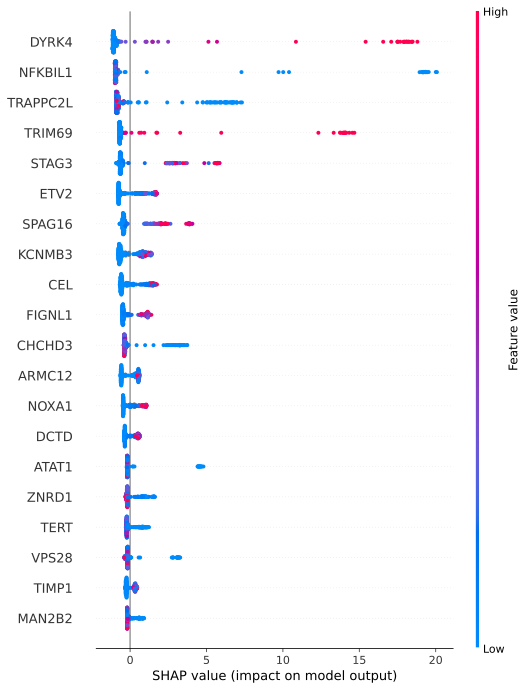

In [32]:
summary_stage_one = stage_one["lifespan"].plot(max_display=200, plot_size=0.5, save = summary_stage_one_plot_path)
summary_stage_one

### Saving stage 1 results ###

In [33]:
for k, v in stage_one.items():
    res = v.select_repeated(2)
    res.to_csv(locations.output.stage_one / f"{k}_selected", sep="\t")

In [34]:
stage_one["lifespan"].select_repeated(2)

,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000010219,DYRK4,10.000,8.375,0.263,8.250,0.261,8.000,0.249,8.000,0.211,8.000,0.265,5.000,0.210,8.250,0.401,8.750,0.226,10.500,0.316,9.000,0.248,10.000,0.246
ENSG00000204498,NFKBIL1,10.000,7.350,-0.141,5.500,-0.057,8.750,-0.030,7.250,-0.114,8.500,-0.190,7.250,-0.178,7.500,-0.082,5.250,-0.044,8.000,-0.312,8.000,-0.095,7.500,-0.305
ENSG00000066923,STAG3,10.000,5.525,0.438,5.250,0.378,4.000,0.397,8.500,0.447,4.000,0.446,6.000,0.505,5.250,0.390,6.250,0.438,5.750,0.511,4.000,0.441,6.250,0.423
ENSG00000185880,TRIM69,10.000,5.200,0.140,5.250,0.073,4.500,0.313,3.750,0.119,4.500,0.155,8.250,0.216,7.000,0.100,5.750,0.086,4.750,0.146,4.000,0.101,4.250,0.089
ENSG00000105672,ETV2,10.000,3.550,0.730,2.750,0.752,3.250,0.769,2.750,0.729,3.750,0.693,5.500,0.701,3.250,0.726,3.750,0.747,3.000,0.707,3.750,0.741,3.750,0.738
ENSG00000167515,TRAPPC2L,9.000,6.056,-0.168,nan,nan,4.750,-0.205,4.750,-0.137,7.750,-0.184,6.000,-0.072,6.250,-0.184,6.750,-0.200,7.000,-0.248,7.000,-0.120,4.250,-0.163
ENSG00000171121,KCNMB3,9.000,4.056,0.667,5.250,0.725,3.750,0.660,nan,nan,3.750,0.669,2.500,0.646,4.500,0.669,3.750,0.616,3.750,0.688,5.000,0.676,4.250,0.654
ENSG00000132436,FIGNL1,9.000,3.722,0.544,4.250,0.475,3.000,0.563,nan,nan,4.000,0.591,3.750,0.571,4.250,0.566,2.500,0.453,3.500,0.544,5.000,0.546,3.250,0.584
ENSG00000157343,ARMC12,9.000,2.639,0.629,3.000,0.625,2.000,0.632,nan,nan,3.250,0.606,1.750,0.626,3.250,0.649,2.250,0.711,3.750,0.610,2.250,0.556,2.250,0.648
ENSG00000170835,CEL,8.000,3.219,0.694,2.500,0.738,3.500,0.748,nan,nan,4.500,0.707,4.250,0.703,2.000,0.695,2.250,0.565,nan,nan,4.250,0.671,2.500,0.723


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [35]:
summary_stage_one.selected.to_csv(locations.output)

AttributeError: 'Figure' object has no attribute 'selected'

In [ ]:
result_untuned = pipelines["lifespan"].fit_transform(stage_two_selection)
result_untuned.selected

In [ ]:
stage_one["lifespan"].plot(max_display=200, plot_size=0.5)

In [ ]:
stage_one["lifespan"].plot(max_display=200, plot_size=0.5)

In [ ]:
summary_stage_two_untuned = result_untuned.plot(max_display=200, plot_size=0.5)
summary_stage_two_untuned

### Comparing metrics ###

In [ ]:
stage_one["lifespan"].metrics_average

In [ ]:
stage_one["lifespan"].symbols_repeated(6).values

In [ ]:
stage_one["lifespan"].symbols_repeated(2).index

In [ ]:
stage_one["lifespan"].validation_metrics.mean(axis=0)

In [ ]:
(stage_one["lifespan"].symbols_repeated(2).shape, result_untuned.symbols_repeated(2).shape)

In [ ]:
result_untuned.metrics_average

In [ ]:
result_untuned.validation_metrics["R^2"].mean()

In [ ]:
#result_untuned.metrics_average

In [ ]:
### Train stage 2 model with same parameters

In [ ]:
result.selected.to_csv()

In [ ]:
locations.output.dir / "stage_one_lifespan.csv"